<a href="https://colab.research.google.com/github/JumperWacky/cycleGAN/blob/main/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas,numpy,random
import matplotlib.pyplot as plt

In [ ]:
# Dataset类，用于data预处理，data传入等
class MnistDataset(Dataset):
  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
  
  def __len__(self):
    return len(self.data_df)
  
  def __getitem__(self, index):
    # 图像label one-hot编码
    label = self.data_df.iloc[index, 0]
    target = torch.zeros(10)
    target[label] = 1.0

    # 图像数据
    # iloc生成一个二维区域，values生成一个numpy.array
    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values) / 255.0

    # 返回标签、图像数据张量及目标张量
    return label, image_values, target
  
  def plot_image(self, index):
    arr = self.data_df.iloc[index, 1:].values.reshape(28, 28)
    plt.title("label = " + str(self.data_df.iloc[index,0]))
    plt.imshow(arr, interpolation='none', cmap='Blues')
    pass

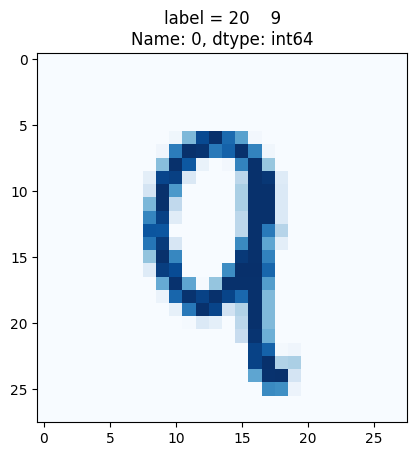

In [37]:
# load Data
mnist_dataset = MnistDataset("/content/sample_data/mnist_train_small.csv")
mnist_dataset.plot_image([20])

In [38]:
def generate_random(size=4):
  random_data = torch.rand(size)
  return random_data

In [39]:
# 构造鉴别器
class Discriminator(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    # 定义神经网路层
    self.model = nn.Sequential(
        nn.Linear(784, 200),
        nn.Sigmoid(),
        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    # 创建损失函数
    self.loss_function = nn.MSELoss()

    # 创建优化器
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # 计数器和进程记录
    self.counter = 0
    self.progress = []

    pass
  
  def forward(self, inputs):
    return self.model(inputs)
  
  def train(self, inputs, targets):
    # 计算网络的输出值
    outputs = self.forward(inputs)
    # 计算损失值
    loss = self.loss_function(outputs, targets)

    # 梯度归零，反向传播，更新权重
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # 每隔10个训练样本增加一次计数器的值，并将损失值添加进列表的末尾
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("dicriminator counter = ", self.counter)
      pass
  
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.',
        grid=True, yticks=(0,0.25,0.5))
    pass

In [40]:
%%time
# 测试鉴别器
D = Discriminator()
for label, image_data_tensor, target_tensor in mnist_dataset:
  # 真实数据
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  # 生成数据
  D.train(generate_random(784), torch.FloatTensor([0.0]))

dicriminator counter =  10000
dicriminator counter =  20000
dicriminator counter =  30000
dicriminator counter =  40000
CPU times: user 44.3 s, sys: 125 ms, total: 44.5 s
Wall time: 50.9 s


0.9906318187713623
0.011577705852687359
0.9888169765472412
0.01018474530428648
0.9928640127182007
0.01041760016232729
0.994769275188446
0.012824389152228832


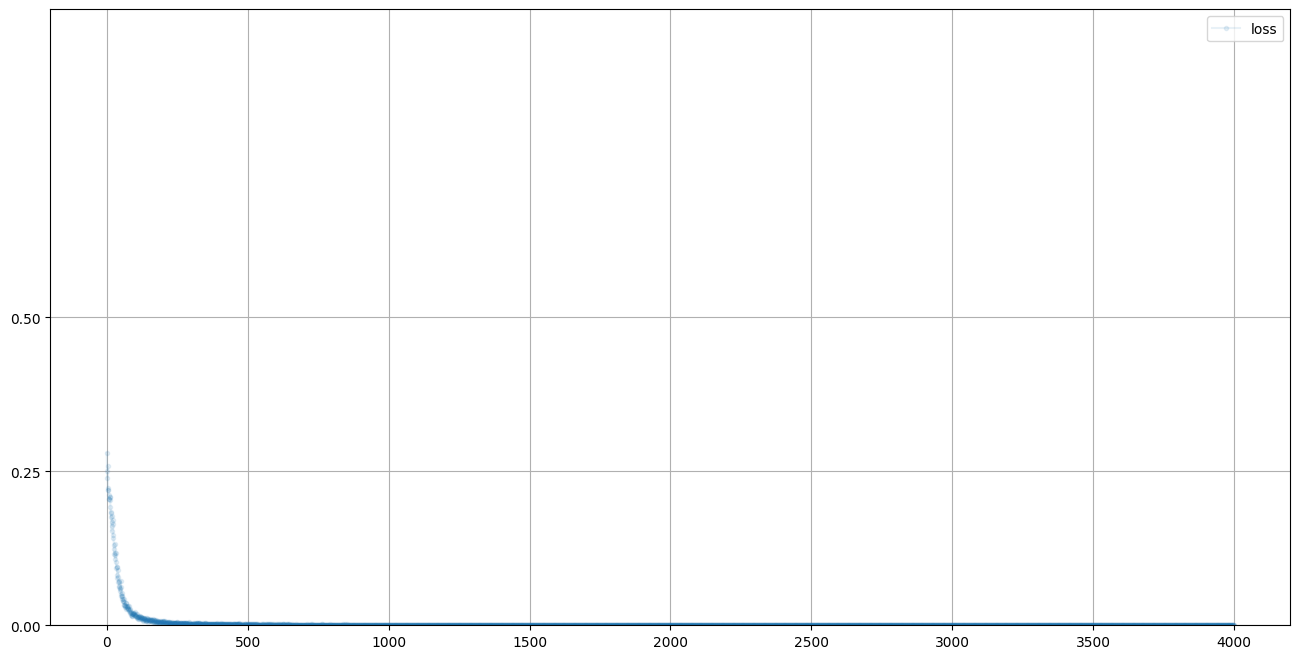

In [ ]:
D.plot_progress()
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 20000)][1]
  print( D.forward(image_data_tensor).item() )
  print( D.forward(generate_random(784)).item() )

In [41]:
# 构造生成器
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    # 定义神经网路层
    self.model = nn.Sequential(
        nn.Linear(1, 200),
        nn.Sigmoid(),
        nn.Linear(200, 784),
        nn.Sigmoid()
    )

    # 创建优化器
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)  # 使用的是生成器的parameters

    # 计数器和进程记录
    self.counter = 0
    self.progress = []

    pass
  
  def forward(self, inputs):
    return self.model(inputs)
  
  def train(self, D, inputs, targets):
    # 计算生成器网络输出
    g_output = self.forward(inputs)

    # 输入鉴别器
    d_output = D.forward(g_output)

    # 计算损失值
    loss = D.loss_function(d_output, targets)
    # 每训练10次增加计数器
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("generator counter = ", self.counter)
      pass
    
    # 梯度归零，反向传播，更新权重
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()    # 只更新生成器的parameter

    pass
  
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.',
        grid=True, yticks=(0,0.25,0.5))
    pass


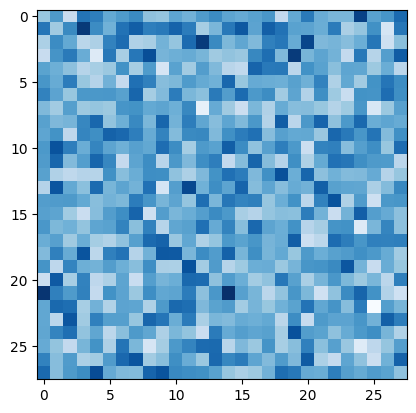

In [ ]:
G = Generator()
output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation='none', cmap='Blues')

In [42]:
%%time
# 创建鉴别器和生成器

D = Discriminator()
G = Generator()

# 训练鉴别器和生成器
for i in range(2):
  for label, image_data_tensor, target_tensor in mnist_dataset:
    # 使用真实数据训练鉴别器
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    # 使用生成数据训练鉴别器
    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))

    # 训练生成器
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

    pass

dicriminator counter =  10000
dicriminator counter =  20000
generator counter =  10000
dicriminator counter =  30000
dicriminator counter =  40000
generator counter =  20000
dicriminator counter =  50000
dicriminator counter =  60000
generator counter =  30000
dicriminator counter =  70000
dicriminator counter =  80000
generator counter =  40000
CPU times: user 2min 30s, sys: 345 ms, total: 2min 31s
Wall time: 2min 33s


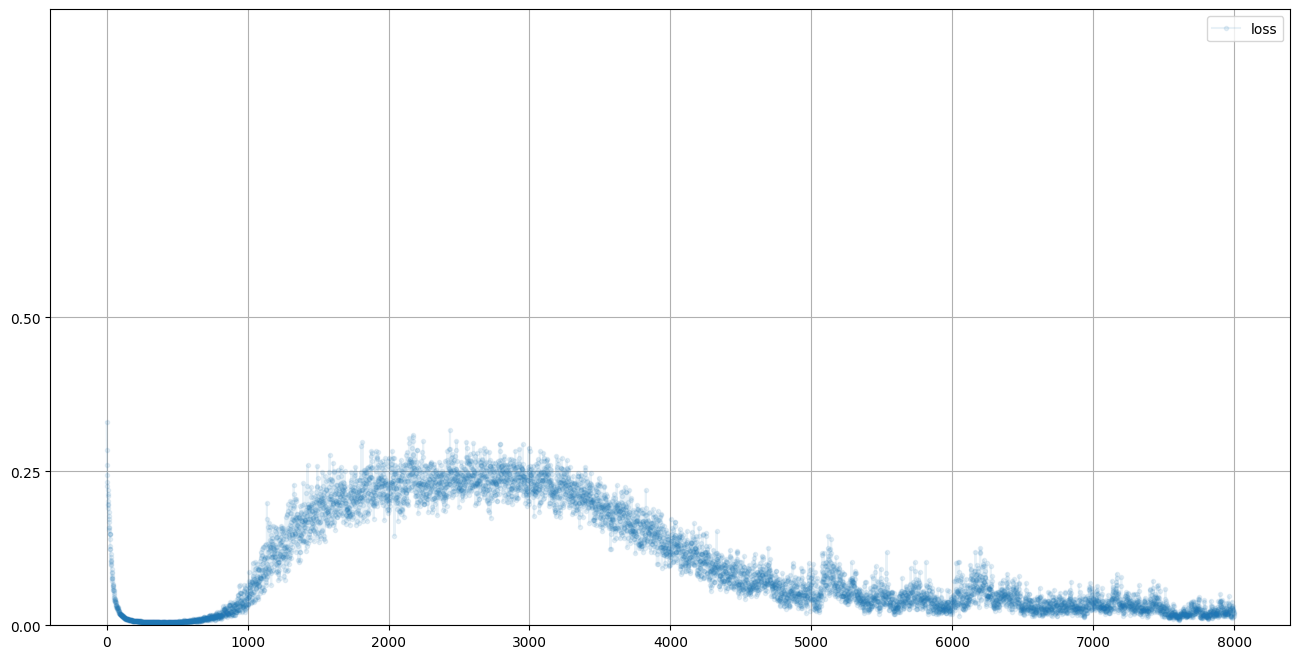

In [43]:
D.plot_progress()

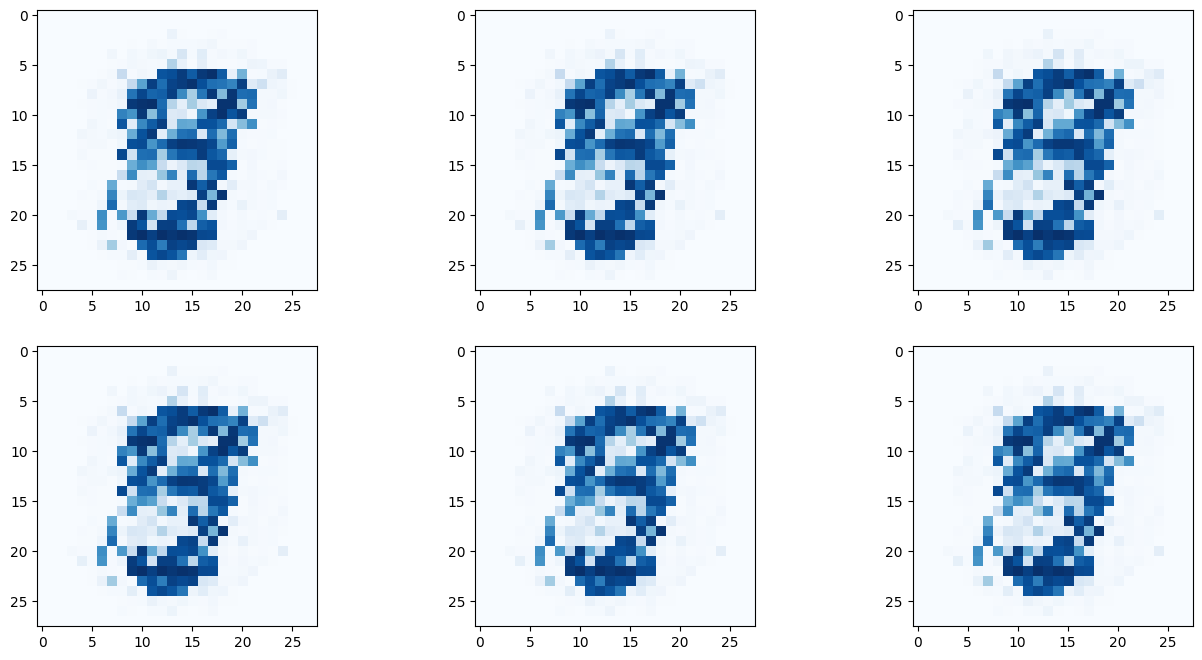

In [46]:
# 在3行2列的网格中生成图像
f, axarr = plt.subplots(2,3,figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random(1))
    img = output.detach().numpy().reshape(28, 28)  # 使用detach将grad置为false，从而可以进行numpy转换
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass